<img src="https://onovia.com/wp-content/uploads/2020/05/lol-logo-rendered-hi-res.png"/>

### **Objetivo do Modelo**:
* Considerando as estatísticas de 10min de uma partida de League of Legends (gold, xp, campeões selecionados, objetivos feitos, etc.), prever o time vencedor da partida (target feature: isWinner_blue).


### **Metodologia**:

* **Obtenção dos Dados**:
    * Dados obtidos pela API da desenvolvedora do jogo - [Riot Games](https://www.riotgames.com/).
    * A API foi utilizada através do [RiotWatcher](https://riot-watcher.readthedocs.io/en/latest/riotwatcher/LeagueOfLegends/index.html), um wrapper leve que facilita o controle de requests.
    * 52 variáveis de mais de 54mil partidas de alto nível do servidor brasileiro.
    
    
* **Preparação dos Dados**:
    * Drop de gameIDs repetidos.
    * Feature Engineering construída a partir de conhecimento do jogo e do EDA - controle de mapa, "bom começo", controle de objetivos, diff de alguns stats importantes, etc.
    * Separação em 2 datasets de acordo com o modelo que será utilizado: boosting machines e lineares.
        * Para o dataset linear, foi realizado padronização e normalização das features contínuas e one-hot-encoding para features categóricas (o que gerou aproximadamente 1,5k de colunas) (`df_linear_sparse`). 
            * A partir desse dataset, foram criados outros dois: 
            * Um com redução do número de features através do drop de campeões outliers (picks abaixo de 0.1% por lane), resultando em 812 features (`df_linear_dropout`).
            * Outro com drop total em colunas contendo campeões, mantendo apenas o "estilo" do campeão escolhido, resultando em 177 features (`df_linear`).
        * O dataset a ser utilizado em boosting machines não recebeu nenhum tipo de normalização e padronização; features categóricas passaram por tratamento de label-encoding. O `df_boosted` é o dataset completo e o `df_boosted_dropout` teve o tratamento de outliers realizado no `df_linear_dropout`.


* **Métricas de Avaliação**:
    * Devido à natureza da label do dataset, não é possível definir uma importância maior a um determinado tipo de erro. Além disso, o dataset é naturalmente estratificado, evitando bias nos scores devido ao desbalanceamento.
    * Nesse sentido, escolhi a acurácia como métrica única de avaliação.
    

* **Baselines**:
    * Considerando a natureza do jogo, defini como baseline uma acurácia de 0.6.
    
    
* **Definição do Modelo**:
    * Como explicado na preparação dos dados, decidi testar modelos baseados em gradient boosting (LightGBM e CatBoost, devido ao seus excelentes suportes para features categóricas) e modelos lineares mais simples, como LogisticRegression, Ridge e Linear Support Vector Machines. 
    * A escolha dos 3 algoritmos lineares foi realizada pelo formato do dataset - sparse e c/ volume médio de observações. 
    
    
 * **Validação**:
    * Os datasets foram separados em 3 partes: set de treino, validação e teste. A separação é dada de acordo com as práticas do livro *Introduction to Machine Learning*, das autoras Andreas C. Müller and Sarah Guido (ed. O’Reilly).
    * Os modelos passaram por validação cruzada no set de treino para identificar a capacidade de generalização de cada algoritmo. 
    * Em seguida, realizei a hiperparametrização treinando os modelos no set de treino e checando os resultados no set de validação.   
    * O modelo com o melhor score na validação é treinado com o set de treino e validação e testado no set de testes, para garantir que não haja vazamento de informações do último set durante as escolhas do algoritmo e dos hiperparâmetros.    

    
* **Hiperparametrização**:
    * Utilizei o Optuna.


* **Modelo Final**:
    * Logistic Regression, com parametro regularizador (C) = 6.407735e-03
    * Acurácia no set de testes: 0.722468
    
    
* **Conclusão**:

Considerando a natureza do dataset e todas as possibilidades que um jogo complexo como League of Legends oferece, eu não esperava nenhum resultado extremamente elevado. Acertar o time vitorioso aos 10min em um jogo que a partida dura entre 30-45min 72% das vezes é um resultado expressivo positivamente. 

Acredito que com um maior volume de dados, um cuidado maior com a área de seleção dos campeões, a adição de dados característicos de cada player (como familiaridade com o campeão escolhido, por ex.) e a adição de features que levem em consideração o *meta* do jogo, seria possível aumentar esse score ainda mais. No entanto, assim como o futebol, o League of Legends é uma caixinha de surpresas pois depende de muito mais do que apenas números - comunicação entre o time, empenho individual e motivação são aspectos que ainda não são possíveis de implementar em um dataset de larga escala como esse.


In [1]:
# Import libs

# Data Wrangling and Analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and Model Selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# ML Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, LinearSVR
from catboost import CatBoostClassifier
import lightgbm as lgbm

# HyperOPT 
import optuna

# eXplainable AI
import shap

Em primeiro momento, carregarei os datasets no pandas:

* **df_linear**: Contém dados normalizados e padronizados (mean = 0), com os campeões separados em roles
* **df_linear_sparse**: Igual ao df_linear, mas sem os campeões separados em roles (n_features > 1.5k)
* **df_linear_dropout**: Igual ao df_linear_sparse, mas com retirada dos outliers nos campeões
* **df_boosted**: Dataset não padronizado, com label encoding nas features categóricas
* **df_boosted_dropout**: Igual ao df_boosted, mas com retirada dos outliers nos campeões
<br>

Após, utilizarei np.random.choice para separar 15% dos gameIDs aleatoriamente de todos os datasets. Esses dados não serão vistos por nenhum modelo e nem serão utilizados para nenhuma tomada de decisão (em relação à escolha do modelo, hiperparametrização, etc.) - apenas no final, para avaliarmos a capacidade de generalização do modelo caso fossem utilizados novos dados.

In [34]:
df_linear.shape

(46002, 177)

In [2]:
df_linear = pd.read_csv('data/df_linear.csv')
df_linear_dropout = pd.read_csv('data/df_linear_dropout.csv')
df_linear_sparse = pd.read_csv('data/df_linear_sparse.csv')
df_boosted = pd.read_csv('data/df_boosted.csv')
df_boosted_dropout = pd.read_csv('data/df_boosted_dropout.csv')

for df in [df_linear, df_linear_dropout, df_linear_sparse, df_boosted, df_boosted_dropout]:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
# Separar 15% para o test set final - usar apenas no modelo final

np.random.seed(42)

# Full datasets
gameids = df_linear.gameID.unique()

testids = np.random.choice(gameids,
                           size=round(0.15*len(gameids)),
                           replace=False)

mask = df_linear.gameID.isin(testids)

df_test_linear = df_linear[mask]
df_linear = df_linear[~mask]

df_test_linear_sparse = df_linear_sparse[mask]
df_linear_sparse = df_linear_sparse[~mask]

df_test_boosted = df_boosted[mask]
df_boosted = df_boosted[~mask]

# Dropout datasets
gameids_dp = df_linear_dropout.gameID.unique()

testids_dp = np.random.choice(gameids_dp,
                              size=round(0.15*len(gameids_dp)),
                              replace=False)

mask_dp = df_linear_dropout.gameID.isin(testids_dp)

df_test_linear_dropout = df_linear_dropout[mask_dp]
df_linear_dropout = df_linear_dropout[~mask_dp]

df_test_boosted_dropout = df_boosted_dropout[mask_dp]
df_boosted_dropout = df_boosted_dropout[~mask_dp]

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


Assim como outros e-sports/esportes, muita coisa pode acontecer numa partida de LoL a partir dos 10min de jogo. Não possuímos dados sobre os jogadores (nada além do campeão selecionado) e suas habilidades, sobre o engajamento e a comunicação do time...

Nesse sentido, gostaria de manter uma **baseline** inicial baixa: **60% de acerto** (acurácia) no resultado final da partida. Além disso, utilizarei também um modelo mais simples - LogisticRegression - para uma baseline mais forte. 

In [4]:
np.random.seed(42)

dataframe_list = [df_linear, df_linear_sparse, df_linear_dropout]

# Baseline - melhor score de logistic regression

for df in dataframe_list:
    
    X = df.drop(['gameID', 'isWinner_blue'], axis=1)
    y = df['isWinner_blue']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
    
    clf = LogisticRegression(max_iter=1000)
    
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    
    print(f'Média 10-fold: {np.mean(scores):.4f}')
    print(f'STD 10-fold:{np.std(scores):.6f}')
    print('==========')

Média 10-fold: 0.7288
STD 10-fold:0.007315
Média 10-fold: 0.7326
STD 10-fold:0.006335
Média 10-fold: 0.7304
STD 10-fold:0.005860


Os resultados entre os datasets foram parecidos, com todas as médias dentro de 1 desvio padrão.

Ainda assim, o **melhor resultado fica com o df_linear_sparse**, aquele em que foram utilizados todos os campeões e possui n_features > 1,5k. Vou agora testar o desempenho dos algoritmos LinearSVC, LinearSVR e Ridge. Os datasets serão separados em set de treino e validação e apenas o set de treino será utilizado para esse teste, em 10-fold Cross-Validation. Isso será feito para que os dados de validação não vazem, deixando-os apenas para a escolha do hiperparâmetro.

In [5]:
def fit_linear_classifiers(dataframe_list, models, tidy_sparse=True):
    
    np.random.seed(42)
    
    score_list = []

    # Baseline - melhor score de logistic regression

    for i, df in enumerate(dataframe_list):

        X = df.drop(['gameID', 'isWinner_blue'], axis=1)
        y = df['isWinner_blue']

        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

        for model in models:
            
            print(f'df_{i}: {model.__name__}')
            
            if model in [LinearSVC, LinearSVR]:
                clf = model(max_iter=100000)
                training_score = clf.fit(X_train, y_train).score(X_train, y_train)
            
            elif model in [LogisticRegression, RidgeClassifier]:
                clf = model(max_iter=2000)
                training_score = clf.fit(X_train, y_train).score(X_train, y_train)
            
            else:
                clf = model()
                training_score = clf.fit(X_train, y_train).score(X_train, y_train)
                
            scores = cross_val_score(clf, X_train, y_train, cv=10)
            
            mean, std = np.mean(scores), np.std(scores)
            
            data = {f'{model.__name__} - 10fold mean accuracy': mean,
                    f'{model.__name__} - 10fold std accuracy': std,
                    f'{model.__name__} - training accuracy': training_score}
            
            if tidy_sparse == True:
                if i == 0:
                    data['data'] = 'df_linear'

                elif i == 1:
                    data['data'] = 'df_linear_sparse'
                    
                else:
                    data['data'] = 'df_linear_dropout'
                    
            else:
                    data['data'] = f'df{i}'
            
            score_list.append(data)
            
    return pd.pivot_table(pd.DataFrame(score_list), index='data')

In [6]:
models = [LogisticRegression, LinearSVC, RidgeClassifier, LinearSVR]

linear_scores = fit_linear_classifiers(dataframe_list, models)

df_0: LogisticRegression
df_0: LinearSVC
df_0: RidgeClassifier
df_0: LinearSVR
df_1: LogisticRegression
df_1: LinearSVC
df_1: RidgeClassifier
df_1: LinearSVR
df_2: LogisticRegression
df_2: LinearSVC
df_2: RidgeClassifier
df_2: LinearSVR


In [7]:
linear_scores

,LinearSVC - 10fold mean accuracy,LinearSVC - 10fold std accuracy,LinearSVC - training accuracy,LinearSVR - 10fold mean accuracy,LinearSVR - 10fold std accuracy,LinearSVR - training accuracy,LogisticRegression - 10fold mean accuracy,LogisticRegression - 10fold std accuracy,LogisticRegression - training accuracy,RidgeClassifier - 10fold mean accuracy,RidgeClassifier - 10fold std accuracy,RidgeClassifier - training accuracy
data,,,,,,,,,,,,
df_linear,0.728993,0.007455,0.732558,0.240997,0.014468,0.249799,0.728820,0.007315,0.732558,0.728878,0.006394,0.732414
df_linear_dropout,0.730366,0.005899,0.748876,0.232143,0.018831,0.279590,0.730366,0.005860,0.748351,0.731003,0.006229,0.749625
df_linear_sparse,0.728762,0.006018,0.757456,0.215451,0.019121,0.291664,0.732559,0.006335,0.755688,0.728414,0.006643,0.756384


O LinearSVR obteve um péssimo resultado, mesmo com um aumento no número de iterações. Vou mexer com a hiperparametrização para tentar achar algum motivo (apesar de que c/ certeza não é overfitting, considerando a acurácia de treino). 

O resto dos modelos obteram resultados próximos, entre 0.72 e 0.73 no set de validação e até 0.755 no set de testes. Os melhores scores foram do LogisticRegression, mas por pouca coisa. 

Entre os datasets, os scores foram bem parecidos também. Utilizarei o df_linear_sparse para fazer a otimização dos hiperparâmetros. 

In [8]:
def linear_objective(trial):
    
    np.random.seed(42)
    
    X = df_linear_sparse.drop(['gameID', 'isWinner_blue'], axis=1)
    y = df_linear_sparse['isWinner_blue']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
    
    classifier_name = trial.suggest_categorical('classifier', ['LinearSVC', 'LogisticRegression', 'RidgeClassifier'])
    
    if classifier_name == 'LinearSVC':
        c = trial.suggest_float('c', 1e-10, 1e10, log=True)
        clf = LinearSVC(C=c, max_iter = 10000)
        
    if classifier_name == 'LinearSVR':
        c = trial.suggest_float('c', 1e-10, 1e10, log=True)
        clf = LinearSVR(C=c, max_iter = 100000)
        
    if classifier_name == 'LogisticRegression':
        c = trial.suggest_float('c', 1e-10, 1e10, log=True)
        clf = LogisticRegression(C=c, max_iter = 10000)
    
    if classifier_name == 'RidgeClassifier':
        alpha = trial.suggest_float('alpha', 1/2*(1e-10), 1/2*(1e10), log=True)
        clf = RidgeClassifier(alpha=alpha, max_iter = 10000)
    
    clf.fit(X_train, y_train)
    
    return clf.score(X_val, y_val)
 

# Reduz o nível do log do optuna -> Comentar essa linha p/ debugging
optuna.logging.set_verbosity(optuna.logging.FATAL)

linear_study = optuna.create_study(direction='maximize')

linear_study.optimize(linear_objective, n_trials=400,
              show_progress_bar = False)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


In [9]:
study_df = linear_study.trials_dataframe()

study_df.sort_values('value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_c,params_classifier,state
330,330,0.737849,2021-04-22 19:01:46.317724,2021-04-22 19:01:49.096348,00:00:02.778624,NaN,6.407735e-03,LogisticRegression,COMPLETE
368,368,0.737588,2021-04-22 19:07:56.724607,2021-04-22 19:08:00.206541,00:00:03.481934,NaN,2.438579e-02,LogisticRegression,COMPLETE
348,348,0.737327,2021-04-22 19:04:19.851491,2021-04-22 19:04:23.456471,00:00:03.604980,NaN,2.528257e-02,LogisticRegression,COMPLETE
331,331,0.737240,2021-04-22 19:01:49.096348,2021-04-22 19:01:51.791954,00:00:02.695606,NaN,5.831648e-03,LogisticRegression,COMPLETE
93,93,0.737240,2021-04-22 18:47:46.508196,2021-04-22 18:47:48.672682,00:00:02.164486,5.027233e+02,NaN,RidgeClassifier,COMPLETE
...,...,...,...,...,...,...,...,...,...
57,57,0.517259,2021-04-22 18:43:53.683944,2021-04-22 18:43:55.081259,00:00:01.397315,NaN,1.173161e-10,LogisticRegression,COMPLETE
363,363,0.517259,2021-04-22 19:06:42.709568,2021-04-22 19:06:44.028864,00:00:01.319296,NaN,1.909813e-07,LogisticRegression,COMPLETE
342,342,0.517259,2021-04-22 19:03:45.855689,2021-04-22 19:03:47.156980,00:00:01.301291,NaN,1.177967e-08,LogisticRegression,COMPLETE
277,277,0.517259,2021-04-22 18:58:44.009151,2021-04-22 18:58:46.135629,00:00:02.126478,2.780593e+08,NaN,RidgeClassifier,COMPLETE


In [27]:
optuna.visualization.plot_contour(linear_study, params=['classifier', 'c'])

In [11]:
optuna.visualization.plot_slice(linear_study, params=['classifier', 'c'])

In [12]:
optuna.visualization.plot_parallel_coordinate(linear_study, params=['classifier', 'c'])

Por final, entre os modelos lineares, o que obteve o melhor resultado foi o Logistic Regression, atingindo score de 0.737849 em diferentes parâmetros e treino tomando apenas 2s. 

Vale notar que a hiperparametrização não mudou muito os scores, causando problemas apenas em valores expressivos. Isso pode configurar um limite (esperado) devido à natureza do problema e do dataset.

## Ensembles

Irei utilizar o CatBOOST e o LightGBM devido aos seus bons desempenhos com features de cardinalidade alta (campeões). Inicialmente testarei entre os 2 datasets preparados para as ensembles:
    * df_boosted
    * df_boosted_dropout (sem campeões outliers)
    
Assim como nos modelos lineares, ambos os datasets serão divididos em set de treino e validação. Em primeiro momento, realizarei a validação cruzada dos modelos no set de treino, além de calcular a acurácia do modelo prever o treino.

Com os resultados, realizarei a hiperparametrização com o Optuna apenas no melhor dataset, com treinamento feito no set de treino e previsões no set de validação.

In [13]:
# Separando as features categóricas

lanes = ['TOP', 'MIDDLE', 'JUNGLE', 'UTILITY', 'BOTTOM']

# Todas que possuem alguma das strings no nome

cat_features = [col for col in df_boosted.columns
                if any(lane in col
                       for lane in lanes)]

In [14]:
# Parâmetros fixados - randomseed, objetivo, etc.

FIXED_PARAMS_LGB = {'objective': 'binary',
                    'metric': 'accuracy',
                    'verbosity': -1,
                    'boosting_type': 'gbdt',
                    'random_seed': 42,
                    'num_boost_round': 2000}

FIXED_PARAMS_CB = {'objective': 'Logloss',
                   'random_seed': 42,
                   'num_boost_round': 2000}

ensemble_score_list = []
param_list = [FIXED_PARAMS_LGB, FIXED_PARAMS_CB]
model_list = ['lgbm', 'cb']

for model, param in zip(model_list, param_list):
    
    for i, df in enumerate([df_boosted, df_boosted_dropout]):

        X = df.drop(['gameID', 'isWinner_blue'], axis=1)
        y = df['isWinner_blue']

        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

        # n estou utilizando o lgb.dataset, é necessário converter as colunas pro index
        param_cat_features = [X.columns.get_loc(col) for col in cat_features]

        if model == 'lgbm':  
            clf = lgbm.LGBMClassifier(categorical_feature=param_cat_features,
                                      verbose_eval=None,
                                      **param)
            
        else:
            clf = CatBoostClassifier(logging_level='Silent',
                                     **param)
            
        scores = cross_val_score(clf, X_train, y_train, cv=10)

        mean, std = np.mean(scores), np.std(scores)
        
        clf.fit(X_train, y_train)
        pred = clf.predict(X_train)
        pred_label = np.rint(pred)
        training_score = accuracy_score(y_train, pred_label)
        
        data = {f'{model} - 10fold mean accuracy': mean,
                f'{model} - 10fold std accuracy': std,
                f'{model} - training accuracy': training_score}

        if i == 0:
            data['data'] = 'df_boosted'

        elif i == 1:
            data['data'] = 'df_boosted_dropout'

        ensemble_score_list.append(data)

df_ensemble_scores = pd.pivot_table(pd.DataFrame(ensemble_score_list), index = 'data')

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1222: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.



[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1222: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.



[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num

In [15]:
df_ensemble_scores

,cb - 10fold mean accuracy,cb - 10fold std accuracy,cb - training accuracy,lgbm - 10fold mean accuracy,lgbm - 10fold std accuracy,lgbm - training accuracy
data,,,,,,
df_boosted,0.729225,0.007377,0.815976,0.722559,0.004578,1.0
df_boosted_dropout,0.726072,0.006271,0.822832,0.720147,0.007199,1.0


Ambos os modelos tiveram resultados muito próximos aos algoritmos mais simples - ainda que inferiores. O CatBoost se deu melhor que o LightGBM em ambos os datasets considerando a média da CV.

Válido notar que ambos os modelos tiveram resultados melhores na acurácia de treino, com o LightGBM alcançando 100% de acurácia. Isso pode significar que o modelo está overfittando (ou não, uma vez que é algo comum para boosting machines). Vamos realizar a hiperparametrização e observar os resultados.

In [16]:
#### LightGBM

# HyperOPT c/ Optuna 

def lightgbm_objective(trial):
    
    np.random.seed(42)
    
    X = df_boosted.drop(['gameID', 'isWinner_blue'], axis=1)
    y = df_boosted['isWinner_blue']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

    # Separa features categóricas -> LGBM lida bem com NaNs e com elas
    train_data = lgbm.Dataset(X_train,
                              label=y_train,
                              categorical_feature = cat_features)
    val_data = lgbm.Dataset(X_val,
                            label=y_val)

    # Hiperparametros Fixos
    
    params = {'objective': 'binary',
              'metric': 'accuracy',
              'verbosity': -1,
              'boosting_type': 'gbdt',
              'random_seed': 42,
              'num_boost_round': 2000,
              'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
              'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
              'num_leaves': trial.suggest_int('num_leaves', 2, 256),
              'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
              'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
              'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
              'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)}
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    
    optuna.logging.set_verbosity(optuna.logging.FATAL)

    # Instancia e Treina o Modelo
    # Os parametros do log da hiperparametrização foram reduzidos p/ evitar a poluição do notebook entregue
    # p/ debugging, remover o show_progress_bar e o verbose_eval
    model_lgbm = lgbm.train(params, train_data,                     
                            valid_sets=[train_data, val_data],
                            verbose_eval=False
                            )
    
    # Resultados Métricas
    pred = model_lgbm.predict(X_val)
    pred_labels = np.rint(pred)
    acc = accuracy_score(y_val, pred_labels)
        
    return acc

                               
study_lgbm = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='maximize')

study_lgbm.optimize(lightgbm_objective, n_trials=100,
                    show_progress_bar = False)

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning:

Using categorical_feature in Dataset.

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['BOTTOM_blue', 'BOTTOM_red', 'JUNGLE_blue', 'JUNGLE_red', 'MIDDLE_blue', 'MIDDLE_red', 'TOP_blue', 'TOP_red', 'UTILITY_blue', 'UTILITY_red', 'roleBOTTOM_blue', 'roleBOTTOM_red', 'roleJUNGLE_blue', 'roleJUNGLE_red', 'roleMIDDLE_blue', 'roleMIDDLE_red', 'roleTOP_blue', 'roleTOP_red', 'roleUTILITY_blue', 'roleUTILITY_red']

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning:

Overriding the parameters from Reference Dataset.

C:\Users\bueni\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning:

categorical_column in param dict is over

In [17]:
study_lgbm_df = study_lgbm.trials_dataframe()

study_lgbm_df

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,state
0,0,0.720285,2021-04-22 19:17:27.865094,2021-04-22 19:17:32.478129,00:00:04.613035,0.589456,7,0.856430,2.864714e-07,0.499002,88,46,COMPLETE
1,1,0.726632,2021-04-22 19:17:32.479130,2021-04-22 19:17:42.235321,00:00:09.756191,0.954928,5,0.905215,3.465634e-06,0.000539,73,159,COMPLETE
2,2,0.722372,2021-04-22 19:17:42.235321,2021-04-22 19:17:51.271351,00:00:09.036030,0.834872,7,0.764995,9.942412e-03,5.796862,25,104,COMPLETE
3,3,0.705852,2021-04-22 19:17:51.271351,2021-04-22 19:17:53.676899,00:00:02.405548,0.536363,6,0.627632,9.731732e-06,0.003467,22,10,COMPLETE
4,4,0.715068,2021-04-22 19:17:53.676899,2021-04-22 19:17:56.247692,00:00:02.570793,0.842829,2,0.799943,2.248857e-06,0.139690,39,8,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.725676,2021-04-22 19:35:50.841649,2021-04-22 19:36:02.546829,00:00:11.705180,0.916072,7,0.755754,2.356585e-07,0.006681,12,183,COMPLETE
96,96,0.724459,2021-04-22 19:36:02.546829,2021-04-22 19:36:14.957623,00:00:12.410794,0.983862,7,0.940333,1.119171e-06,0.013114,25,188,COMPLETE
97,97,0.726893,2021-04-22 19:36:14.957623,2021-04-22 19:36:26.146136,00:00:11.188513,0.962195,6,0.687780,7.123981e-03,0.001223,16,148,COMPLETE
98,98,0.730197,2021-04-22 19:36:26.147137,2021-04-22 19:36:36.382841,00:00:10.235704,0.932104,6,0.611821,1.069797e-04,0.002687,10,137,COMPLETE


In [29]:
study_lgbm_df.sort_values('value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,state
98,98,0.730197,2021-04-22 19:36:26.147137,2021-04-22 19:36:36.382841,00:00:10.235704,0.932104,6,0.611821,1.069797e-04,0.002687,10,137,COMPLETE
33,33,0.729241,2021-04-22 19:23:13.674629,2021-04-22 19:23:26.192949,00:00:12.518320,0.942944,7,0.729745,1.030974e-07,0.001388,23,230,COMPLETE
87,87,0.728980,2021-04-22 19:34:17.034784,2021-04-22 19:34:28.840659,00:00:11.805875,0.920422,6,0.671865,6.159722e-07,0.000343,13,193,COMPLETE
20,20,0.728719,2021-04-22 19:20:23.107139,2021-04-22 19:20:39.377707,00:00:16.270568,0.994404,6,0.938859,9.861580e-07,0.007819,5,256,COMPLETE
29,29,0.728545,2021-04-22 19:22:31.244766,2021-04-22 19:22:41.219009,00:00:09.974243,0.783644,7,0.777494,7.670632e-07,0.762975,32,178,COMPLETE


Apesar do Optuna ter selecionado alguns parâmetros regularizadores, o resultado não melhorou muito - chegou a 0.73 no teste de validação. Ainda assim, quero mexer manualmente nesses hiperparâmetros e reduzir a regulariazação, testando uma redução no número de leaves.

In [19]:
# HyperOPT c/ Optuna 

def cb_objective(trial):
    
    np.random.seed(42)
    
    X = df_boosted.drop(['gameID', 'isWinner_blue'], axis=1)
    y = df_boosted['isWinner_blue']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

    params = {
        'objective': 'Logloss',
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 1, 12),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical(
            'bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'used_ram_limit': '12gb'}

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    optuna.logging.set_verbosity(optuna.logging.FATAL)

    # Instancia e Treina o Modelo
    # Os parametros do log da hiperparametrização foram reduzidos p/ evitar a poluição do notebook entregue
    # p/ debugging, remover o show_progress_bar e o verbose_eval
    model_cb = CatBoostClassifier(logging_level='Silent', **params)
    
    model_cb.fit(X_train, y_train,
                 eval_set=[(X_val, y_val)],
                 verbose=0,
                 cat_features = cat_features,
                 early_stopping_rounds=100)
    
    # Resultados Métricas
    pred = model_cb.predict(X_val)
    pred_labels = np.rint(pred)
    acc = accuracy_score(y_val, pred_labels)
        
    return acc
                           
study_cb = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='maximize')

study_cb.optimize(cb_objective, n_trials=100,
                  show_progress_bar=False)

In [20]:
study_cb_df = study_cb.trials_dataframe()

study_cb_df

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_subsample,state
0,0,0.730632,2021-04-22 19:36:43.907532,2021-04-22 19:37:00.095884,00:00:16.188352,NaN,Plain,Bernoulli,0.098627,6,0.857330,COMPLETE
1,1,0.731241,2021-04-22 19:37:00.095884,2021-04-22 19:37:14.763661,00:00:14.667777,NaN,Plain,Bernoulli,0.076408,7,0.468485,COMPLETE
2,2,0.726719,2021-04-22 19:37:14.763661,2021-04-22 19:37:27.286615,00:00:12.522954,NaN,Plain,Bernoulli,0.023322,10,0.901839,COMPLETE
3,3,0.729937,2021-04-22 19:37:27.286615,2021-04-22 19:37:39.553348,00:00:12.266733,NaN,Plain,Bernoulli,0.029669,9,0.832263,COMPLETE
4,4,0.730545,2021-04-22 19:37:39.553348,2021-04-22 19:37:54.822594,00:00:15.269246,NaN,Plain,Bernoulli,0.084967,6,0.553557,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.728632,2021-04-22 20:07:56.582439,2021-04-22 20:08:12.487871,00:00:15.905432,NaN,Plain,Bernoulli,0.081575,8,0.169637,COMPLETE
96,96,0.727154,2021-04-22 20:08:12.487871,2021-04-22 20:08:32.424712,00:00:19.936841,NaN,Plain,Bernoulli,0.092175,10,0.452404,COMPLETE
97,97,0.726893,2021-04-22 20:08:32.424712,2021-04-22 20:08:46.820010,00:00:14.395298,NaN,Plain,Bernoulli,0.046435,3,0.280483,COMPLETE
98,98,0.726806,2021-04-22 20:08:46.820010,2021-04-22 20:09:00.506362,00:00:13.686352,NaN,Plain,MVS,0.064944,9,NaN,COMPLETE


In [21]:
study_cb_df.sort_values('value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_subsample,state
1,1,0.731241,2021-04-22 19:37:00.095884,2021-04-22 19:37:14.763661,00:00:14.667777,NaN,Plain,Bernoulli,0.076408,7,0.468485,COMPLETE
77,77,0.730980,2021-04-22 20:03:09.686924,2021-04-22 20:03:25.009322,00:00:15.322398,NaN,Plain,MVS,0.066384,4,NaN,COMPLETE
0,0,0.730632,2021-04-22 19:36:43.907532,2021-04-22 19:37:00.095884,00:00:16.188352,NaN,Plain,Bernoulli,0.098627,6,0.857330,COMPLETE
4,4,0.730545,2021-04-22 19:37:39.553348,2021-04-22 19:37:54.822594,00:00:15.269246,NaN,Plain,Bernoulli,0.084967,6,0.553557,COMPLETE
69,69,0.730371,2021-04-22 20:00:50.825469,2021-04-22 20:01:08.909109,00:00:18.083640,3.154712,Plain,Bayesian,0.078682,6,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
19,19,0.725241,2021-04-22 19:44:15.723345,2021-04-22 19:44:24.823389,00:00:09.100044,NaN,Plain,Bernoulli,0.010245,5,0.660832,COMPLETE
68,68,0.725154,2021-04-22 20:00:36.696479,2021-04-22 20:00:50.825469,00:00:14.128990,8.973605,Ordered,Bayesian,0.093772,1,NaN,COMPLETE
54,54,0.725154,2021-04-22 19:57:00.701724,2021-04-22 19:57:09.410590,00:00:08.708866,NaN,Plain,Bernoulli,0.071900,1,0.272481,COMPLETE
20,20,0.725067,2021-04-22 19:44:24.823389,2021-04-22 19:45:14.800176,00:00:49.976787,NaN,Plain,MVS,0.071396,12,NaN,COMPLETE


Os resultados do CatBoost foram superiores aos do LGBM, mas não o suficiente para ele ser o modelo a ser utilizado no set de testes.

Nenhum dos modelos baseados em gradient boosting bateu a acurácia do LogisticRegression (na verdade, de quase nenhum dos outros  modelos lineares - única exceção é o LinearSVR). Irei utilizar-lo para o prever o dataset de testes (separado no início desse notebook) e chegar num resultado final:

In [22]:
np.random.seed(42)

# Train: todo o restante do dataset
X_train = df_linear_sparse.drop(['gameID', 'isWinner_blue'], axis=1)
y_train = df_linear_sparse['isWinner_blue']

# Test: separado no início de forma aleatória
X_test = df_test_linear_sparse.drop(['gameID', 'isWinner_blue'], axis=1)
y_test = df_test_linear_sparse['isWinner_blue']

clf = LogisticRegression(C=linear_study.best_params['c'])
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

In [23]:
accuracy_score(pred, y_test)

0.7224685883222468

Em um set nunca visto por nenhum dos algoritmos, **o Logistic Regression bateu 0.72247 de acurácia** - o que é extremamente interessante para mim. Alcançar > 70% de probabilidade de acertar o time vencedor de uma partida aos 10min de jogo (considerando que partidas podem levar de 30-45min) é bem valioso.
<br>

Vamos observar a matriz de confusão. Lembrando que **erros do Tipo I (Falso Positivos) aqui são** aqueles em que o **modelo preveu que o time azul ganhou, mas o time vermelho foi o vencedor** final. Já os do **Tipo II (Falso Negativos) são** o oposto. Modelo **prevê que o time azul perdeu e ele ganhou**. 

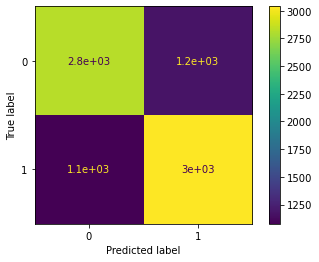

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(estimator=clf,
                      X=X_test,
                      y_true=y_test);

> "**O League of Legends é uma caixinha de surpresas**"<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **IGN** - sobre o Rift Rivals, campeonato internacional de LoL
                                  
Os erros estão distribuídos para os dois lados: vitória ou derrota do time azul. Considerando a igualdade entre as estatísticas descritivas de ambos os times, essa distribuição era esperada. 

Esse resultado dá ainda mais força ao que foi dito anteriormente sobre a dificuldade de realizar a previsão devido à natureza do dataset e de jogos competitivos. Por final, utilizarei a lib SHAP para dar uma olhada nas features do modelo - como o dataset utilizado era o df_linear_sparse que contém >1,5k features, focarei apenas nas 20 mais importantes.

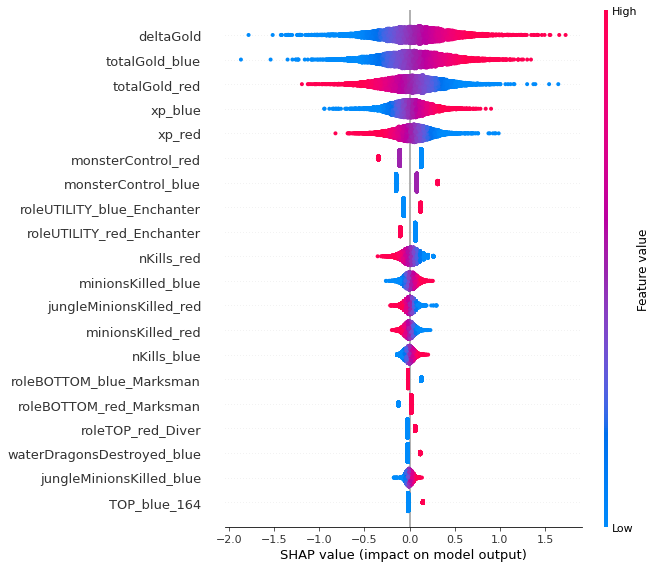

In [25]:
explainer = shap.LinearExplainer(clf, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

Obs.: Apesar das cores serem as mesmas de cada um dos times, elas não tem haver com isso. Vermelho significa valores altos/positivos, enquanto azul significa valores baixos/negativos/zero. Quando uma barra vai para o lado direito, indica que o valor daquela feature - dado com a cor - aumenta a probabilidade da previsão de que o time azul foi o vencedor. O contrário é válido.  

Alguns dos resultados são esperados e outros nem tanto. Como foi visto na análise exploratória dos dados, o gold e o XP acumulado pelo time até os 10min são fundamentais para a medição do desempenho dele.

No entanto, em muitas partidas, principalmente as competitivas, 10min de jogo não é o suficiente para a criação de grandes diferenças entre os dois times nesses stats - o que dificulta a previsão do resultado correto da partida (dado que os times estão "iguais"). 

Logo abaixo, está o controle dos monstros do mapa - feature criada durante o estágio de feature engineering. Nota-se que a obtenção dos monstros possui importância para o modelo. Isso foi explicado no EDA: monstros dão buffs positivos para o time que conseguir eliminá-los, além do controle de mapa prévio necessário para que o objetivo seja feito.

Entre os pontos interessantes, está a importância positiva que o modelo deu para suportes do tipo enchanter e negativa para ADCs ára ambos os times. Além disso, a vigésima feature mais importante do modelo é a escolha de Camille TOP para o time azul - um dos campeões mais escolhidos de acordo com o EDA.